#GPU Loading

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


##1. Data Extraction and Loading

In [ ]:
import zipfile
import os

zip_file_name = "archive (20).zip"
extract_folder = "emotion_data"

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Check the extracted contents
print("Extracted files:")
os.listdir(extract_folder)


Extracted files:


['train', 'test']

In [ ]:
print("Contents of 'emotion_data':", os.listdir(extract_folder))
print("Train folder:", os.listdir(os.path.join(extract_folder, "train")))
print("Test folder:", os.listdir(os.path.join(extract_folder, "test")))


Contents of 'emotion_data': ['train', 'test']
Train folder: ['fear', 'disgust', 'neutral', 'sad', 'surprise', 'happy', 'angry']
Test folder: ['fear', 'disgust', 'neutral', 'sad', 'surprise', 'happy', 'angry']


##2. Data Preprocessing with ImageDataGenerator

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 2.1 Define paths to the train/test directories
train_dir = os.path.join(extract_folder, "train")
test_dir = os.path.join(extract_folder, "test")

# 2.2 Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# 2.3 Flow from Directory
batch_size = 64
target_size = (48, 48)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


##3. Model Architecture, Compiling, Training, and Testing

In [ ]:
!nvidia-smi

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(target_size[0], target_size[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))  # 7 classes
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# View summary
model.summary()

# Model training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Fri Jan  3 15:41:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              29W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,474,759 (9.44 MB)

 Trainable params: 2,472,839 (9.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - accuracy: 0.1725 - loss: 2.8786 - val_accuracy: 0.1807 - val_loss: 2.2770
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.1927 - loss: 2.4380 - val_accuracy: 0.2767 - val_loss: 1.8129
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.2148 - loss: 2.2663 - val_accuracy: 0.2924 - val_loss: 1.7625
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.2259 - loss: 2.1601 - val_accuracy: 0.3061 - val_loss: 1.7236
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.2314 - loss: 2.0894 - val_accuracy: 0.2991 - val_loss: 1.7293
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.2547 - loss: 2.0110 - val_accuracy: 0.3369 - val_loss: 1.6451
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.2664 - loss: 1.9492 - val_accuracy: 0.3158 - val_loss: 1.7826
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.2840 - loss: 1.8873 - val_accurac

##4. Model Evaluation

###4.1. Plotting Training Curves: 'Accuracy vs Epoch' and 'Loss vs Epoch'

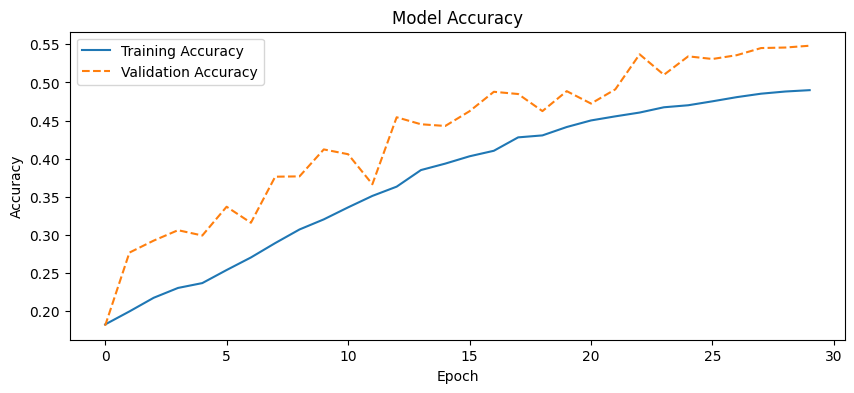

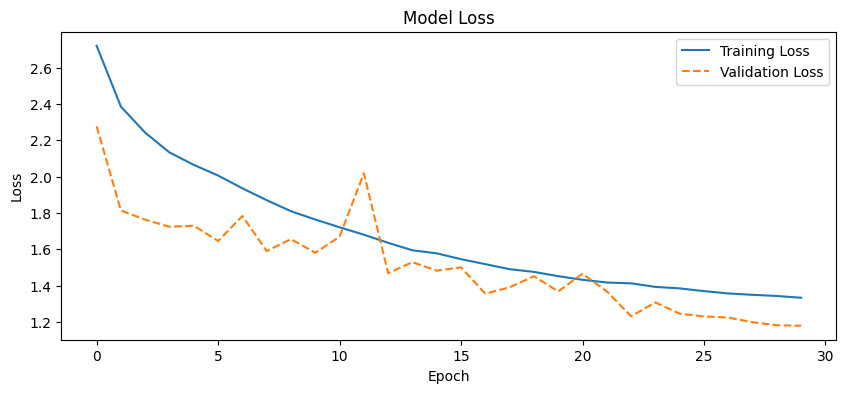

In [ ]:
import matplotlib.pyplot as plt

# 4.1.1 Plot Training & Validation Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 4.1.2 Plot Training & Validation Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


###4.2. Classification Report

In [ ]:
import numpy as np
import math

# Reset the test_generator before prediction
test_generator.reset()

steps_for_test = math.ceil(test_generator.samples / test_generator.batch_size)
print(steps_for_test)  # Should be 113

# Predict probabilities for the test set
pred_probs = model.predict(
    test_generator,
    steps=steps_for_test,
    verbose=1
)

pred_probs = pred_probs[:test_generator.samples]

# Confirm the shape
print("pred_probs shape:", pred_probs.shape)

# Convert probabilities to class indices
pred_classes = np.argmax(pred_probs, axis=1)

# Get true class indices from the test generator
true_classes = test_generator.classes  # The ground truth labels
class_labels = list(test_generator.class_indices.keys())  # e.g. ['angry', 'disgust', ...]

print(len(pred_classes), len(true_classes))  # Both should be 7178


113
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
pred_probs shape: (7178, 7)
7178 7178


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, pred_classes, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

       angry       0.42      0.50      0.46       958
     disgust       0.46      0.21      0.29       111
        fear       0.37      0.09      0.15      1024
       happy       0.84      0.76      0.80      1774
     neutral       0.43      0.70      0.53      1233
         sad       0.46      0.38      0.42      1247
    surprise       0.61      0.77      0.68       831

    accuracy                           0.55      7178
   macro avg       0.51      0.49      0.47      7178
weighted avg       0.55      0.55      0.53      7178



###4.3. Confusion Matrix

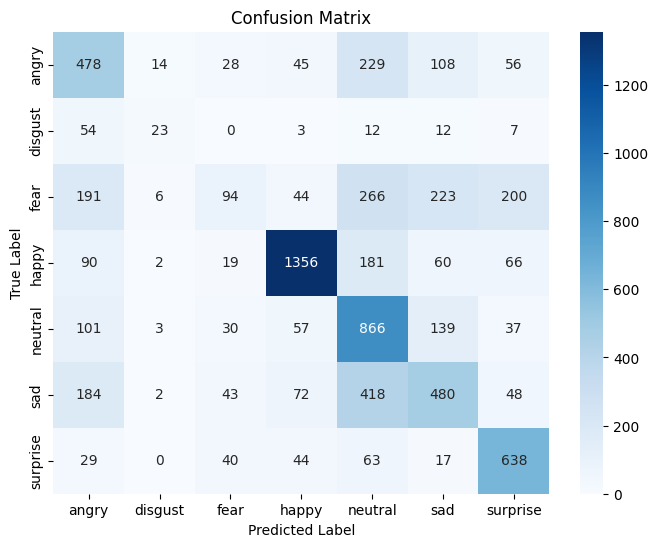

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
